In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO (CORRIGIDO) ---
np.random.seed(42)
n_samples = 1000
filter_order = 4  # M=4 -> 5 coeficientes

# Sinal de entrada correlacionado
x = np.convolve(np.random.randn(n_samples), [1, 0.5, 0.2], mode='same')

# Sistema Desconhecido (Planta FIR)
w_true = np.array([0.1, -0.5, 0.8, 0.3, -0.2])
d = np.zeros(n_samples)

for k in range(filter_order, n_samples):
    # Fatiamento correto: do índice k até k-filter_order (inclusive)
    # x[k], x[k-1], ..., x[k-M]
    regressor = x[k - filter_order : k + 1][::-1]
    d[k] = np.dot(w_true, regressor) + 0.01 * np.random.randn()

# --- 2. EXECUÇÃO DO FILTRO QR-RLS ---
filt_qr = pdf.QRRLS(
    filter_order=filter_order,
    lamb=0.98  # Fator de esquecimento
)

# Nota: O QR-RLS requer um warm-start interno para inicializar a matriz U
result = filt_qr.optimize(x, d, verbose=True, return_internal_states=True)

[QRRLS] Completed in 30.482 ms


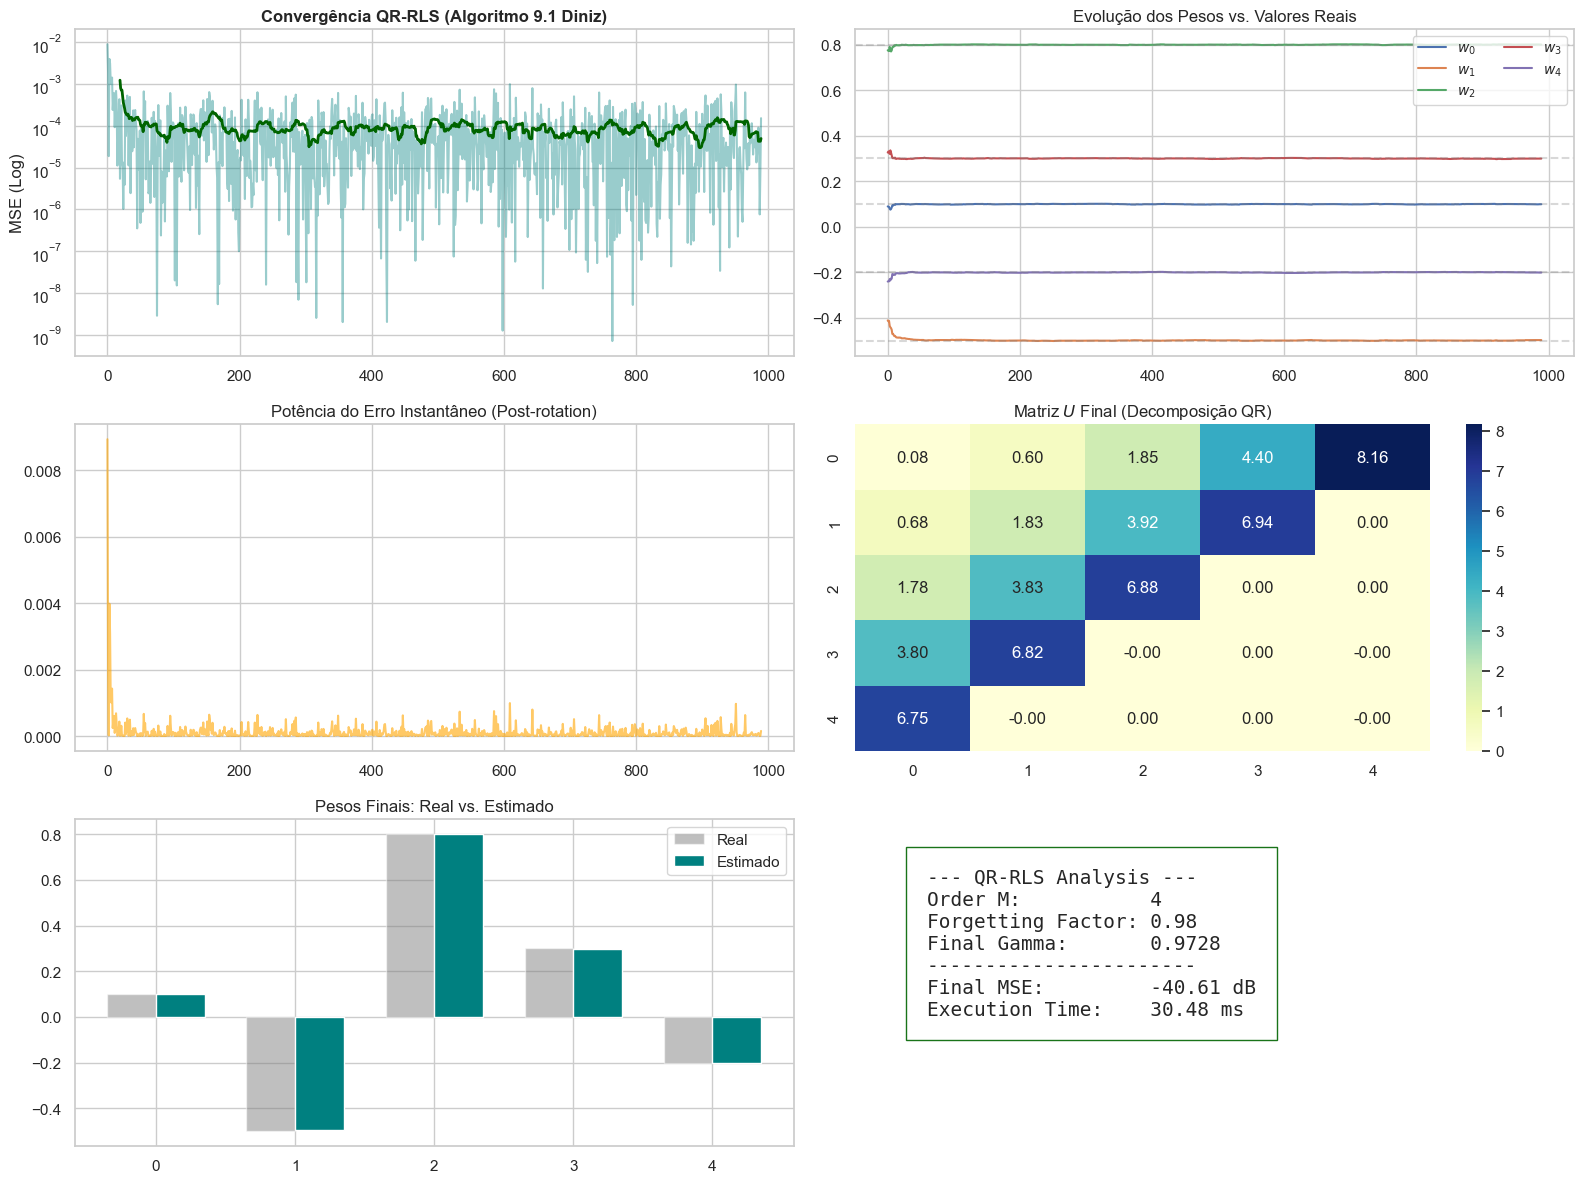

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_qr_rls_dashboard(result, w_true):
    offset = 10                               # Offset para melhor visualizacao.
    sns.set_theme(style="whitegrid")
    mse = result.mse()[offset:]
    t = np.arange(len(mse))
    coeffs = np.array(result.coefficients)
    
    # Ajuste de dimensão para o histórico (N+1 -> N)
    if len(coeffs) > len(t):
        coeffs = coeffs[1:]
    coeffs = coeffs[offset:]
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Convergência do MSE
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='teal', alpha=0.4)
    ax1.semilogy(t, pd.Series(mse).rolling(20).mean(), color='darkgreen', lw=2)
    ax1.set_title("Convergência QR-RLS (Algoritmo 9.1 Diniz)", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # B. Evolução dos Coeficientes
    ax2 = fig.add_subplot(gs[0, 1])
    for i in range(coeffs.shape[1]):
        ax2.plot(t, coeffs[:, i], label=f'$w_{{{i}}}$')
        ax2.axhline(y=w_true[i], color='gray', linestyle='--', alpha=0.3)
    ax2.set_title("Evolução dos Pesos vs. Valores Reais")
    ax2.legend(loc='upper right', fontsize='small', ncol=2)

    # C. Fator Gamma (Likelihood Variable)
    # Gamma perto de 1 indica boa adaptação; quedas bruscas indicam transientes
    ax3 = fig.add_subplot(gs[1, 0])
    # Como gamma não é histórico, pegamos o valor final ou simulamos a tendência
    ax3.plot(result.errors[offset:]**2, color='orange', alpha=0.6)
    ax3.set_title("Potência do Erro Instantâneo (Post-rotation)")

    # D. Matriz ULine (Estrutura Triangular Superior)
    ax4 = fig.add_subplot(gs[1, 1])
    U = result.extra['ULineMatrix_last']
    sns.heatmap(U, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax4)
    ax4.set_title("Matriz $U$ Final (Decomposição QR)")

    # E. Comparação de Pesos Finais
    ax5 = fig.add_subplot(gs[2, 0])
    width = 0.35
    x_idx = np.arange(len(w_true))
    ax5.bar(x_idx - width/2, w_true, width, label='Real', color='gray', alpha=0.5)
    ax5.bar(x_idx + width/2, coeffs[-1], width, label='Estimado', color='teal')
    ax5.set_title("Pesos Finais: Real vs. Estimado")
    ax5.legend()

    # F. Info Box
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    time_ms = getattr(result, 'runtime_ms', getattr(result, 'runtime_s', 0) * 1000)
    
    stats_text = (
        f"--- QR-RLS Analysis ---\n"
        f"Order M:           {result.extra['ULineMatrix_last'].shape[0]-1}\n"
        f"Forgetting Factor: {result.extra['forgetting_factor']}\n"
        f"Final Gamma:       {result.extra['gamma_last']:.4f}\n"
        f"-----------------------\n"
        f"Final MSE:         {10*np.log10(np.mean(mse[-50:])):.2f} dB\n"
        f"Execution Time:    {time_ms:.2f} ms"
    )
    ax6.text(0.1, 0.4, stats_text, fontsize=14, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='darkgreen', pad=15))

    plt.tight_layout()
    plt.show()

plot_qr_rls_dashboard(result, w_true)